**Postpocessing script for Diablo output**
_Script to subset/sample mean_prof_stat.nc output file, clean up repeated coordinate values, calculate some common quanties and add useful attributes, to the end of making the data small enough and intuive enough to share :)_

In [20]:
%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

In [21]:
### read in from NetCDF
datastr = "/Users/madi/Desktop/Diablo/Diablo_runs/DC/DC_noshear/"
fname = '%smean_prof_stat.nc'% datastr
    
ds = xr.open_dataset(fname)

In [22]:
### remove duplicated y and t values
_, index = np.unique(ds['y'], return_index=True)
dtmp = ds.isel(y=index)

_, index = np.unique(dtmp['t'], return_index=True)
dtmp = dtmp.isel(t=index)

In [23]:
### Subsample (in time) if time array is unecessarily dense! More than 
#1 data point per 15 mins seems a reasonable cutoff for most uses
nhours = (dtmp.t[-2]/3600)
NT = len(ds.t)
dT_minutes = 15
NT_light = nhours.round()*(60/dT_minutes)
if NT>NT_light:
    print('yep, sub-sampling in t')
    t_light = np.linspace(0,dtmp.t[-2],NT_light)
    dtmp = dtmp.sel(t=t_light, method='nearest')


yep, sub-sampling in t


In [24]:
## domain unnecessarily deep for some early cases. Restrict to 10 m
if dtmp.y[-2]>10:
    dtmp = dtmp.sel(y=slice(None, 10.05))
    print('yep, sub-sampling in y')

yep, sub-sampling in y


In [25]:
### Calc new quantities + assign to existing Dataset
#TKE
dtmp = dtmp.assign(TKE=lambda dtmp: dtmp.U_RMS **2 + dtmp.V_RMS**2 + dtmp.W_RMS**2)

#N2
alpha = 3.8e-5
beta = 7.8e-4
dTdy = dtmp.Temp.differentiate("y")
dSdy = dtmp.Sal.differentiate("y")
dtmp=dtmp.assign(N2=lambda dtmp: 9.81*(-alpha*dTdy + beta*dSdy))

In [26]:
### tidy/rename
# Remove some infrequently used variables for a small, upload-able + useful dataset
dtmp = dtmp.drop(['tke_mean', 'Temp_grad', 'Sal_grad', 'u_grad', 'w_grad', 
                  'uv', 'wv', 'uw', 'bprod', 'Sal_rms', 'Temp_rms', 'U_RMS', 'V_RMS', 'W_RMS'])
# rename some of the variables to make them more easily recognisable
dtmp = dtmp.rename({"UME_TOT": "U", "WME_TOT": "W",
             "sprod": "Shear_production","diss": "Dissipation" , "thvt": "vpTp", "thvs": "vpSp"})


In [27]:
dtmp

<xarray.Dataset>
Dimensions:           (t: 844, x: 64, y: 482, z: 64)
Coordinates:
  * x                 (x) float64 0.0 0.07812 0.1562 ... 4.766 4.844 4.922
  * y                 (y) float64 0.0008804 0.002649 0.004432 ... 9.951 10.02
  * z                 (z) float64 0.0 0.07812 0.1562 ... 4.766 4.844 4.922
  * t                 (t) float64 0.0 799.7 1.8e+03 ... 7.575e+05 7.58e+05
Data variables:
    U                 (t, y) float64 ...
    W                 (t, y) float64 ...
    Temp              (t, y) float64 9.969e+36 9.969e+36 ... -2.091 -2.09
    Sal               (t, y) float64 9.969e+36 9.969e+36 9.969e+36 ... 34.5 34.5
    Shear_production  (t, y) float64 ...
    Dissipation       (t, y) float64 ...
    vpSp              (t, y) float64 ...
    vpTp              (t, y) float64 ...
    TKE               (t, y) float64 2.982e+74 2.982e+74 ... 2.772e-11 2.813e-11
    N2                (t, y) float64 0.0 0.0 0.0 ... 2.706e-06 2.706e-06

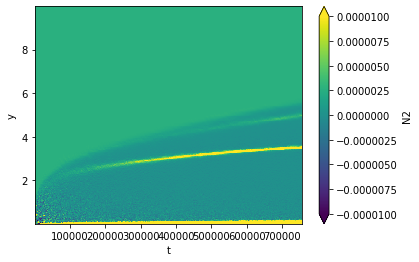

In [28]:
### Have a look at N**2
dtmp.N2[1:-1,1:-1].transpose().plot(vmin = -1e-5, vmax =1e-5)

In [29]:
### add units
dtmp.U.attrs["units"] = "m/s"
dtmp.W.attrs["units"] = "m/s"
dtmp.Temp.attrs["units"] = "deg. C"
dtmp.Sal.attrs["units"] = "g/kg"
dtmp.Dissipation.attrs["units"] = "m^2 s**(-3)"
dtmp.Shear_production.attrs["units"] = "m^2 s**(-3)"
dtmp.vpTp.attrs["units"] = "m deg. C s**(-1)"
dtmp.vpSp.attrs["units"] = "m g (kg s)**(-1)"
dtmp.TKE.attrs["units"] = "m^2 s**(-2)"
dtmp.N2.attrs["units"] = "s**(-2)"

In [30]:
### add long names
dtmp.U.attrs["long name"] = "x-component of velocity"
dtmp.W.attrs["long name"] = "z-component of velocity"
dtmp.Dissipation.attrs["long name"] = "turbulence dissipation (epsilon)"
dtmp.Shear_production.attrs["long name"] = "shear production of turbulence"
dtmp.vpTp.attrs["long name"] = "v'T'"
dtmp.vpSp.attrs["long name"] = "v'S'"
dtmp.TKE.attrs["long name"] = "Turbulent Kinetic Energy"
dtmp.N2.attrs["long name"] = "Squared Brunt-Vaisala/Buoyancy frequency"

In [31]:
fname = '%sOUTPUT_light.nc'% datastr
print ('saving to ', fname)

dtmp.to_netcdf(path=fname)
print ('finished saving')

saving to  /Users/madi/Desktop/Diablo/Diablo_runs/DC/DC_noshear/OUTPUT_light.nc
finished saving


**Do the same for the subgridscale quantities**. _We care about even fewer of these_

In [32]:
### read in from NetCDF
fname = '%smean_prof_les_stat.nc'% datastr
    
ds = xr.open_dataset(fname)

In [33]:
### remove duplicated y and t values
_, index = np.unique(ds['y'], return_index=True)
dtmp = ds.isel(y=index)

_, index = np.unique(dtmp['t'], return_index=True)
dtmp = dtmp.isel(t=index)

In [34]:
### tidy/rename
# Remove some infrequently used variables for a small, upload-able + useful dataset
dtmp = dtmp.drop(['TAU11', 'TAU22', 'TAU33', 'TAU12', 'TAU13', 
                  'TAU23', 'tke_sgs_t', 'C_DYN', 'C_DYN_dot', 'NU_T_test', 'NU_T_mean'])
# rename some of the variables to make them more easily recognisable
dtmp = dtmp.rename({"tke_sgs_p": "shear_prod_sgs", "tke_sgs_diss": "dissipation_sgs"})


In [35]:
### Subsample (in time) if time array is unecessarily dense! More than 
#1 data point per 15 mins seems a reasonable cutoff for most uses
nhours = (dtmp.t[-2]/3600)
NT = len(ds.t)
dT_minutes = 15
NT_light = nhours.round()*(60/dT_minutes)
if NT>NT_light:
    print('yep, sub-sampling in t')
    t_light = np.linspace(0,dtmp.t[-2],NT_light)
    dtmp = dtmp.sel(t=t_light, method='nearest')

yep, sub-sampling in t


In [36]:
## domain unnecessarily deep for some early cases. Restrict to 10 m
if dtmp.y[-2]>10:
    dtmp = dtmp.sel(y=slice(None, 10.05))
    print('yep, sub-sampling in y')

yep, sub-sampling in y


In [37]:
### add units
dtmp.shear_prod_sgs.attrs["units"] = "m^2 s**(-3)"
dtmp.dissipation_sgs.attrs["units"] = "m^2 s**(-3)"

In [38]:
fname = '%sOUTPUT_SGS_light.nc'% datastr
print ('saving to ', fname)

dtmp.to_netcdf(path=fname)
print ('finished saving')

saving to  /Users/madi/Desktop/Diablo/Diablo_runs/DC/DC_noshear/OUTPUT_SGS_light.nc
finished saving
